In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

import matplotlib.ticker as plticker

import re

import scienceplots
import matplotlib.pyplot as plt

plt.style.use('science')
plt.rcParams['figure.figsize'] = (9, 3)

In [2]:
from nltk import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

from transformers import AutoTokenizer


from collections import defaultdict

# Results Setup 

In [ ]:
def load_VAD_lexicons():
    VAD_path = './NRC-VAD-Lexicon.txt'
    with open(VAD_path, 'r') as infile:
        lines = infile.read()
        lines = lines.split("\n")
        
        vad_dict = {}
        
        for l in lines:            
            lexicon, v_score, a_score, d_score = l.split("\t")

            vad_dict[lexicon] = {
                'v': float(v_score),
                'a': float(a_score),
                'd': float(d_score)
            }
        
        return vad_dict

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()
vad_dict = load_VAD_lexicons()

## Functions 

In [3]:
def ext_cov(source, pred, remove_words = []):
    source = re.sub(r'[^\w\s]', '', source.lower())
    pred   = re.sub(r'[^\w\s]', '', pred.lower())
    
    source_toks = set(word_tokenize(source)).difference(set(remove_words))
    pred_toks   = set(word_tokenize(pred)).difference(set(remove_words))
    
    num_ext = len([w for w in pred_toks if w in source_toks])
    if len(pred_toks) > 0:
        return num_ext/len(pred_toks)
    else:
        return 0
        

def get_side(op, r):
    if re.sub(r'[^\w\s]', '', op.lower()[:30]) in re.sub(r'[^\w\s]', '', r['left_op'].lower()):
        return 'left'
    elif re.sub(r'[^\w\s]', '', op.lower()[:30]) in re.sub(r'[^\w\s]', '', r['right_op'].lower()):
        return 'right'
    else:
        return 'neither'
    
def ext_analyze_row(row, reference = False):
    alt_ops = row['alt_op'].split('\n')
    sides = [get_side(op, row) for op in alt_ops]
    pos   = np.arange(len(alt_ops))
    if reference:
        spl, spr, mpl, mpr = sent_tokenize(row['left_sum'])[0], sent_tokenize(row['right_sum'])[0], sent_tokenize(row['left_sum'])[0], sent_tokenize(row['right_sum'])[0]
    else:
        spl, spr, mpl, mpr = sent_tokenize(row['sp_left_pred'])[0], sent_tokenize(row['sp_right_pred'])[0], sent_tokenize(row['mp_left_pred'])[0], sent_tokenize(row['mp_right_pred'])[0]
    spl_scores = [ext_cov(alt_op, spl) for alt_op in alt_ops]
    spr_scores = [ext_cov(alt_op, spr) for alt_op in alt_ops]
    mpl_scores = [ext_cov(alt_op, mpl) for alt_op in alt_ops]
    mpr_scores = [ext_cov(alt_op, mpr) for alt_op in alt_ops]
    
    # Calculate extraction ignoring terms that appear in all source documents, consider only unique words 
    # Done so that analyzing length bias is unbiased by purely including more tokens
    ignore_toks = set(re.sub(r'[^\w\s]', '', alt_ops[0].lower()))
    for op in alt_ops[1:]:
        op_toks = word_tokenize(re.sub(r'[^\w\s]', '', op.lower()))
        ignore_toks = ignore_toks.union(set(op_toks))
        
    spl_scores_unq = [ext_cov(alt_op, spl, remove_words = ignore_toks) for alt_op in alt_ops]
    spr_scores_unq = [ext_cov(alt_op, spr, remove_words = ignore_toks) for alt_op in alt_ops]
    mpl_scores_unq = [ext_cov(alt_op, mpl, remove_words = ignore_toks) for alt_op in alt_ops]
    mpr_scores_unq = [ext_cov(alt_op, mpr, remove_words = ignore_toks) for alt_op in alt_ops]
    
    arous_pairs = [get_arous_scores(alt_op) for alt_op in alt_ops]
    num_arouss, arous_scores = [sc[0] for sc in arous_pairs], [sc[1] for sc in arous_pairs]
    lengths = [len(re.split('\s+', op)) for op in alt_ops]
    perc_arouss = [num_arous/length for num_arous, length in zip(num_arouss, lengths)]
    
    
    
    ext_res = pd.DataFrame({
      'title_date_side': row['title_date_side'],
      'pos': pos,
      'side': sides,
      'length': lengths,
      'spl_ext': spl_scores,
      'spr_ext': spr_scores,
      'mpl_ext': mpl_scores,
      'mpr_ext': mpr_scores,
      'spl_ext_unq': spl_scores_unq,
      'spr_ext_unq': spr_scores_unq,
      'mpl_ext_unq': mpl_scores_unq,
      'mpr_ext_unq': mpr_scores_unq,
      'num_arous': num_arouss,
      'perc_arous': perc_arouss,
      'arous_score': arous_scores,
    })
    
    return ext_res

In [4]:
def preprocess_text(text, join_again=True):
    text = text.replace("U.S.", "USA")
    text = text.lower()
    text = re.sub(r'[^\w\s]','',text)
    tokens = [wordnet_lemmatizer.lemmatize(w) for w in word_tokenize(text)]
    
    if join_again:
        text = " ".join(tokens)
        return text
    else:
        return tokens

In [5]:
def get_arous_scores(source):
    source_split = word_tokenize(preprocess_text(source))
    
    num_arous, num_pol, arous_score = 0, 0, 0
    for tok in source_split:
        if tok in vad_dict:
            if vad_dict[tok]['v'] <= 0.35 or vad_dict[tok]['v'] >= 0.65:
                num_arous += 1 if vad_dict[tok]['a'] > 0.65 else 0
                num_pol += 1
                arous_score += vad_dict[tok]['a']
    if num_pol > 0:
        return num_arous, arous_score/num_pol
    else:
        return 0, 0
    
def bin_scores(scores, num_bins = 10):
    bins = [np.percentile(scores.values, 100./num_bins * i) for i in range(1, num_bins + 1)] 
    
    score_bins = []
    for score in scores:
        for i, sbin in enumerate(bins):
            if score <= sbin:
                score_bins.append(i)
                break
    return score_bins

In [6]:
def make_extract_res(preds, reference = False):
    ext_res = [] 
    for row in tqdm(preds.to_dict(orient = 'records')):
        ext_res.append(ext_analyze_row(row, reference = reference))
    ext_res = pd.concat(ext_res)
    return ext_res

def make_pos_res(ext_res):
    pos_avgs = defaultdict(list)
    for pos in range(10):
        subset = ext_res[ext_res['pos'] == pos]
        lsubset = subset[subset['side'] == 'left']
        rsubset = subset[subset['side'] == 'right']

        pos_avgs['pos'].append(pos)
        pos_avgs['mpl_ext'].append(lsubset['mpl_ext'].mean())
        pos_avgs['mpr_ext'].append(rsubset['mpr_ext'].mean())
        pos_avgs['mpl_ext_std'].append(lsubset['mpl_ext'].std() * 1.96 / len(lsubset)**0.5)
        pos_avgs['mpr_ext_std'].append(rsubset['mpr_ext'].std() * 1.96 / len(rsubset)**0.5)
        pos_avgs['mpl_count'].append(len(lsubset))
        pos_avgs['mpr_count'].append(len(rsubset))
    return pd.DataFrame(pos_avgs)

def make_side_res(ext_res):
    side_avg = {
        'left_left': ext_res[(ext_res['side'] == 'left') & (ext_res['pos'] < 4)]['mpl_ext'].mean(),
        'left_right': ext_res[(ext_res['side'] == 'right') & (ext_res['pos'] < 4)]['mpl_ext'].mean(),
        'right_left': ext_res[(ext_res['side'] == 'left') & (ext_res['pos'] < 4)]['mpr_ext'].mean(),
        'right_right': ext_res[(ext_res['side'] == 'right') & (ext_res['pos'] < 4)]['mpr_ext'].mean(),
        'left_left_std': ext_res[(ext_res['side'] == 'left') & (ext_res['pos'] < 4)]['mpl_ext'].std() * 1.96 / np.sqrt(len(ext_res[(ext_res['side'] == 'left') & (ext_res['pos'] < 5)]['mpl_ext'])),
        'left_right_std': ext_res[(ext_res['side'] == 'right') & (ext_res['pos'] < 4)]['mpl_ext'].std() * 1.96 / np.sqrt(len(ext_res[(ext_res['side'] == 'right') & (ext_res['pos'] < 5)]['mpl_ext'])),
        'right_left_std': ext_res[(ext_res['side'] == 'left') & (ext_res['pos'] < 4)]['mpr_ext'].std() * 1.96 / np.sqrt(len(ext_res[(ext_res['side'] == 'left') & (ext_res['pos'] < 5)]['mpr_ext'])),
        'right_right_std': ext_res[(ext_res['side'] == 'right') & (ext_res['pos'] < 4)]['mpr_ext'].std() * 1.96 / np.sqrt(len(ext_res[(ext_res['side'] == 'right') & (ext_res['pos'] < 5)]['mpr_ext']))
    }
    
    return side_avg

def make_arous_res(ext_res, num_bins = 10, max_num_docs = 4):
    ext_res['arous_bin'] = bin_scores(ext_res['arous_score'], num_bins = num_bins)
    
    arous_res = ext_res[ext_res['pos'] < max_num_docs].groupby('arous_bin').mean(numeric_only = True)
        
    return arous_res

def make_narous_res(ext_res, num_bins = 10, max_num_docs = 4):
    ext_res['parous_bin'] = bin_scores(ext_res['perc_arous'], num_bins = num_bins)

    arous_res_raw = ext_res[ext_res['pos'] < max_num_docs].groupby('parous_bin')
    arous_res = arous_res_raw.mean(numeric_only = True)
    arous_std = arous_res_raw.std(numeric_only = True) * 1.96 / (arous_res_raw.count() ** 0.5)
    arous_std.columns = [col + '_std' for col in arous_std.columns]
    arous_res = pd.concat([arous_res, arous_std], axis = 1)
        
    return arous_res

def make_length_res(ext_res, num_bins = 10, max_num_docs = 4):
    ext_res['length_bin'] = bin_scores(ext_res['length'], num_bins = num_bins)
    
    length_res_raw = ext_res[ext_res['pos'] < max_num_docs].groupby('length_bin')
    length_res = length_res_raw.mean(numeric_only = True)
    length_std = length_res_raw.std(numeric_only = True) * 1.96 / (length_res_raw.count() ** 0.5)
    length_std.columns = [col + '_std' for col in length_std.columns]
    length_res = pd.concat([length_res, length_std], axis = 1)
    
    return length_res

## Preprocessing 

In [12]:
models = ['bart-large-cnn', 't5-large', 'flan-t5-large', 'Mistral-7B-Instruct-v0.1-backup', 
          'mixtral-8x22b-instruct-backup', 'vicuna-7b-v1.5', 'vicuna-13b-v1.5', 'Meta-Llama-3-8B-Instruct', 'llama-v3-70b-instruct', 'llama-v3p3-70b-instruct', 'gpt4-o', 'reference']
model_names = ['BART', 'T5', 'Flan-T5', 'Mistral', 'Mixtral', 'Vicuna (7B)', 'Vicuna (13B)', 'Llama-3.0 (8B)', 'Llama-3.0 (70B)', 'Llama-3.3 (70B)', 'GPT-4o', 'Reference']

In [ ]:
all_preds = {model: pd.read_csv(f'results/{model}/preds.csv') for model in models[:-1]}

In [14]:
all_preds['ref'] = all_preds['gpt4-o']

In [15]:
for model, preds in all_preds.items():
    all_preds[model][f'title_date_side'] = all_preds[model].progress_apply(lambda row: get_side(row['alt_op'], row), axis = 1)

  0%|          | 0/2070 [00:00<?, ?it/s]

  0%|          | 0/2070 [00:00<?, ?it/s]

  0%|          | 0/2070 [00:00<?, ?it/s]

  0%|          | 0/2070 [00:00<?, ?it/s]

  0%|          | 0/2070 [00:00<?, ?it/s]

  0%|          | 0/2070 [00:00<?, ?it/s]

  0%|          | 0/2070 [00:00<?, ?it/s]

  0%|          | 0/2070 [00:00<?, ?it/s]

  0%|          | 0/2070 [00:00<?, ?it/s]

  0%|          | 0/2070 [00:00<?, ?it/s]

  0%|          | 0/2070 [00:00<?, ?it/s]

  0%|          | 0/2070 [00:00<?, ?it/s]

In [16]:
for model, preds in all_preds.items():
    right_cov = preds.apply(lambda row: ext_cov(row['alt_op'], row['mp_right_pred']), axis = 1)
    left_cov = preds.apply(lambda row: ext_cov(row['alt_op'], row['mp_left_pred']), axis = 1)
    
    print(f'{model}: {left_cov.mean():.2f} {right_cov.mean():.2f} {left_cov.mean()/2 + right_cov.mean()/2:.2f}')

bart-large-cnn: 0.91 0.91 0.91
t5-large: 0.77 0.79 0.78
flan-t5-large: 0.84 0.84 0.84
Mistral-7B-Instruct-v0.1-backup: 0.83 0.84 0.83
mixtral-8x22b-instruct-backup: 0.71 0.73 0.72
vicuna-7b-v1.5: 0.79 0.81 0.80
vicuna-13b-v1.5: 0.72 0.69 0.71
Meta-Llama-3-8B-Instruct: 0.69 0.71 0.70
llama-v3-70b-instruct: 0.69 0.71 0.70
llama-v3p3-70b-instruct: 0.64 0.66 0.65
gpt4-o: 0.65 0.67 0.66
ref: 0.65 0.67 0.66


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('meta-llama/Meta-Llama-3-8B-Instruct')

In [ ]:
for model, preds in all_preds.items():
    right_len = preds['mp_left_pred'].apply(lambda sum_pred: len(tokenizer(sum_pred, add_special_tokens = False)['input_ids']))
    left_len  = preds['mp_right_pred'].apply(lambda sum_pred: len(tokenizer(sum_pred, add_special_tokens = False)['input_ids']))
    
    print(f'{model:40s}: {left_len.mean():.1f} {right_len.mean():.1f} {left_len.mean()/2 + right_len.mean()/2:.1f}')

In [ ]:
right_len = preds['left_sum'].apply(lambda sum_pred: len(tokenizer(sum_pred, add_special_tokens = False)['input_ids']))
left_len  = preds['right_sum'].apply(lambda sum_pred: len(tokenizer(sum_pred, add_special_tokens = False)['input_ids']))
print(f'Ref: {left_len.mean():.1f} {right_len.mean():.1f} {left_len.mean()/2 + right_len.mean()/2:.1f}')

In [ ]:
right_cov = preds.apply(lambda row: ext_cov(row['alt_op'], row['right_sum']), axis = 1)
left_cov = preds.apply(lambda row: ext_cov(row['alt_op'], row['left_sum']), axis = 1)
print(f'Ref: {left_cov.mean():.2f} {right_cov.mean():.2f}')

In [18]:
ext_ress = {model: make_extract_res(preds) if model != 'ref' else make_extract_res(preds, reference = True) for model, preds in all_preds.items()}

  0%|          | 0/2070 [00:00<?, ?it/s]

  0%|          | 0/2070 [00:00<?, ?it/s]

  0%|          | 0/2070 [00:00<?, ?it/s]

  0%|          | 0/2070 [00:00<?, ?it/s]

  0%|          | 0/2070 [00:00<?, ?it/s]

  0%|          | 0/2070 [00:00<?, ?it/s]

  0%|          | 0/2070 [00:00<?, ?it/s]

  0%|          | 0/2070 [00:00<?, ?it/s]

  0%|          | 0/2070 [00:00<?, ?it/s]

  0%|          | 0/2070 [00:00<?, ?it/s]

  0%|          | 0/2070 [00:00<?, ?it/s]

  0%|          | 0/2070 [00:00<?, ?it/s]

In [19]:
pos_ress  = {model: make_pos_res(ext_res) for model, ext_res in ext_ress.items()}
side_ress = {model: make_side_res(ext_res) for model, ext_res in ext_ress.items()}
arous_ress = {model: make_arous_res(ext_res, num_bins = 20, max_num_docs = 4) for model, ext_res in ext_ress.items()}
narous_ress = {model: make_narous_res(ext_res, max_num_docs = 4) for model, ext_res in ext_ress.items()}
length_ress = {model: make_length_res(ext_res, max_num_docs = 4) for model, ext_res in ext_ress.items()}

In [20]:
side_ress = pd.DataFrame(side_ress).transpose()

# Extraction Figures 

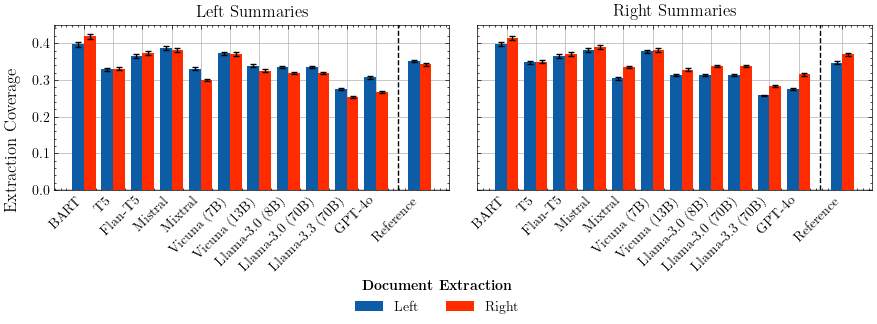

In [25]:
width = 0.4
alpha = 0.25

fig, axs = plt.subplots(1, 2, figsize = (9, 3), sharey = True)

ref_offset = np.zeros(len(models))
ref_offset[-1] = .5

axs[0].bar(np.arange(len(models)) + ref_offset - width/2, side_ress['left_left'], yerr = side_ress['left_left_std'], width = width, label = 'Left', capsize = 2, zorder = 3)
axs[0].bar(np.arange(len(models)) + ref_offset + width/2, side_ress['left_right'], yerr = side_ress['left_right_std'], width = width, label = 'Right', color = 'C3', capsize = 2, zorder = 3)

axs[0].set_xticks(np.arange(len(models)) + ref_offset, model_names, rotation = 45, ha = 'right')
axs[0].axhline(y=0, color='black')

axs[1].bar(np.arange(len(models)) + ref_offset - width/2, side_ress['right_left'], yerr = side_ress['right_left_std'], width = width, capsize = 2, zorder = 3)
axs[1].bar(np.arange(len(models)) + ref_offset + width/2, side_ress['right_right'], yerr = side_ress['right_right_std'], width = width, color = 'C3', capsize = 2, zorder = 3)

axs[1].set_xticks(np.arange(len(models)) + ref_offset, model_names, rotation = 45, ha = 'right')
axs[1].axhline(y=0, color='black')

axs[0].plot([len(models) - 1.25, len(models) - 1.25], [0, 0.5], color = 'black', linestyle = '--')
axs[1].plot([len(models) - 1.25, len(models) - 1.25], [0, 0.5], color = 'black', linestyle = '--')
plt.ylim(0, .45)


axs[0].set_title('Left Summaries')
axs[1].set_title('Right Summaries')

fig.supylabel('Extraction Coverage')

fig.legend(title = r'\textbf{Document Extraction}', ncol = 2, loc = 'lower center', bbox_to_anchor = (0.5, -0.12))

axs[0].grid(zorder = 1)
axs[1].grid(zorder = 1)

fig.tight_layout()
plt.savefig('figures/side_extraction_clipped.png', dpi = 600)

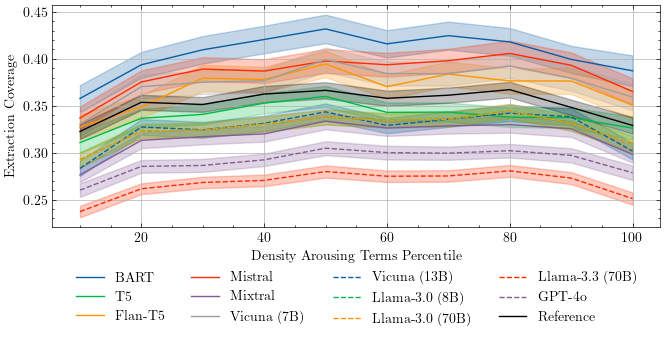

In [49]:
plt.rcParams['figure.figsize'] = (7, 4)
for i, (model, arous_res) in enumerate(narous_ress.items()):
    linestyle = '--' if i >= 6 else '-'
    color = f'C{i}' if i < 5 else f'C{i+1}'
    if i == len(length_ress) - 1:
        color = 'black'
        linestyle = '-'

    arous_res['mp_ext'] = (arous_res['mpl_ext'] + arous_res['mpr_ext']) / 2
    arous_res['mp_ext_std'] = (arous_res['mpl_ext_std'] + arous_res['mpr_ext_std']) / 2
    
    plt.plot((arous_res.index.get_level_values('parous_bin') + 1) * 10, arous_res['mp_ext'], label = model_names[i], color = color, linestyle = linestyle)

    plt.fill_between((arous_res.index.get_level_values('parous_bin') + 1) * 10, 
                     np.array(arous_res['mp_ext']) - np.array(arous_res['mp_ext_std']), 
                     np.array(arous_res['mp_ext']) + np.array(arous_res['mp_ext_std']),
                    alpha = alpha, color = color)

plt.ylabel('Extraction Coverage')
plt.xlabel('Density Arousing Terms Percentile')
    
plt.legend(ncols = len(models)//3, loc = 'lower center', bbox_to_anchor = (0.5, -0.5))


plt.grid()

plt.tight_layout()
plt.savefig('figures/narous_extraction_avg_clipped.png', dpi = 600)

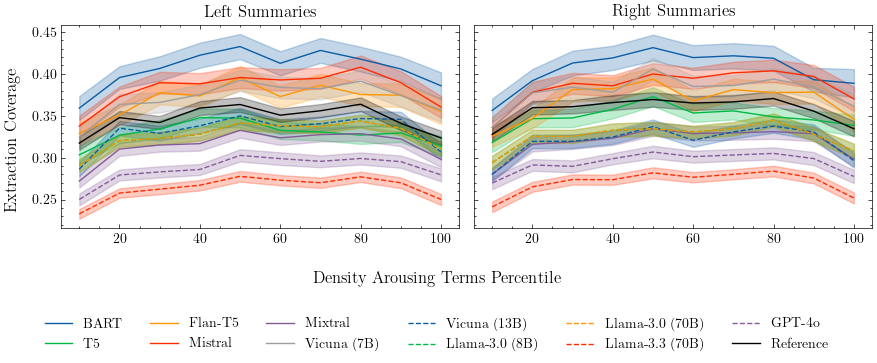

In [34]:
fig, axs = plt.subplots(1, 2, figsize = (9, 3), sharey = True)

for i, (model, arous_res) in enumerate(narous_ress.items()):
    
    linestyle = '--' if i >= 6 else '-'
    color = f'C{i}' if i < 5 else f'C{i+1}'
    if i == len(length_ress) - 1:
        color = 'black'
        linestyle = '-'

        
    lsubset, rsubset = arous_res, arous_res
    axs[0].plot((lsubset.index.get_level_values('parous_bin') + 1) * 10, lsubset['mpl_ext'], label = model_names[i], linestyle = linestyle, color = color)

    axs[0].fill_between((lsubset.index.get_level_values('parous_bin') + 1) * 10, 
                     np.array(lsubset['mpl_ext']) - np.array(lsubset['mpl_ext_std']), 
                     np.array(lsubset['mpl_ext']) + np.array(lsubset['mpl_ext_std']),
                        color = color,
                     alpha = alpha)
    
    # axs[1].plot((rsubset.index.get_level_values('narous_bin') + 1) * 5, (rsubset['mpr_ext'] - rsubset['mpr_ext'].min())/(rsubset['mpr_ext'].max() - rsubset['mpr_ext'].min()), label = model_names[i])
    axs[1].plot((rsubset.index.get_level_values('parous_bin') + 1) * 10, rsubset['mpr_ext'], linestyle = linestyle, color = color)

    axs[1].fill_between((lsubset.index.get_level_values('parous_bin') + 1) * 10, 
                     np.array(lsubset['mpr_ext']) - np.array(lsubset['mpr_ext_std']), 
                     np.array(lsubset['mpr_ext']) + np.array(lsubset['mpr_ext_std']),
                        color = color,
                    alpha = alpha)

fig.supylabel('Extraction Coverage')
fig.supxlabel('Density Arousing Terms Percentile')

# axs[0].set_xticks(np.arange(20))
# axs[1].set_xticks(np.arange(20))

axs[0].set_title('Left Summaries')
axs[1].set_title('Right Summaries')
    
fig.legend(ncols = len(models)//2, loc = 'lower center', bbox_to_anchor = (0.5, -0.25))

fig.tight_layout()
plt.savefig('figures/narous_extraction_clipped.png', dpi = 600)

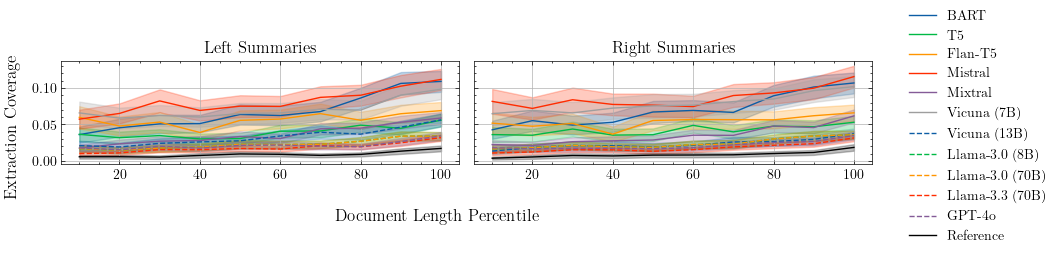

In [33]:
fig, axs = plt.subplots(1, 2, figsize = (9, 2), sharey = True)

for i, (model, length_res) in enumerate(length_ress.items()):
    linestyle = '--' if i >= 6 else '-'
    color = f'C{i}' if i < 5 else f'C{i+1}'
    if i == len(length_ress) - 1:
        color = 'black'
        linestyle = '-'

        
    lsubset, rsubset = length_res, length_res
    axs[0].plot((lsubset.index.get_level_values('length_bin') + 1) * 10, lsubset['mpl_ext_unq'], label = model_names[i], linestyle = linestyle, color = color)

    axs[0].fill_between((lsubset.index.get_level_values('length_bin') + 1) * 10, 
                     np.array(lsubset['mpl_ext_unq']) - np.array(lsubset['mpl_ext_unq_std']), 
                     np.array(lsubset['mpl_ext_unq']) + np.array(lsubset['mpl_ext_unq_std']),
                        color = color,
                    alpha = alpha)
    
    axs[1].plot((rsubset.index.get_level_values('length_bin') + 1) * 10, rsubset['mpr_ext_unq'], linestyle = linestyle, color = color)

    axs[1].fill_between((rsubset.index.get_level_values('length_bin') + 1) * 10, 
                     np.array(rsubset['mpr_ext_unq']) - np.array(rsubset['mpr_ext_unq_std']), 
                     np.array(rsubset['mpr_ext_unq']) + np.array(rsubset['mpr_ext_unq_std']),
                        color = color,
                    alpha = alpha)

fig.supylabel('Extraction Coverage')
fig.supxlabel('Document Length Percentile')

axs[0].set_title('Left Summaries')
axs[1].set_title('Right Summaries')

axs[0].grid()
axs[1].grid()
    
fig.legend(ncols = 1, loc = 'center left', bbox_to_anchor = (1.01, 0.5))

fig.tight_layout()
plt.savefig('figures/unique_length_bias_clipped.png', dpi = 600)

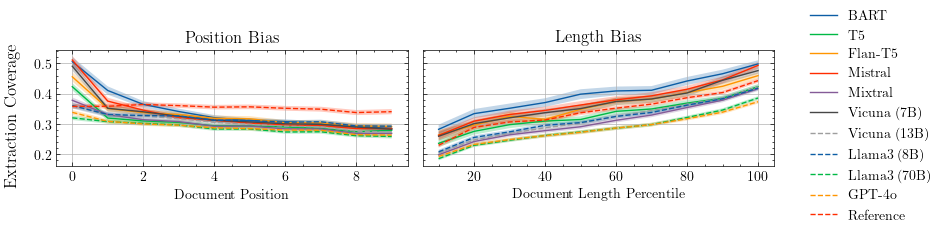

In [633]:
fig, axs = plt.subplots(1, 2, figsize = (8, 2), sharey = True)

for i, ((model, length_res), (model, pos_res)) in enumerate(zip(length_ress.items(), pos_ress.items())):
    
    linestyle = '--' if i >= 6 else '-'
    
    pos_res['mp_ext'] = (pos_res['mpl_ext'] + pos_res['mpr_ext']) / 2
    pos_res['mp_ext_std'] = (pos_res['mpl_ext_std'] + pos_res['mpr_ext_std']) / 2
    axs[0].plot(np.array(pos_res['pos']), pos_res['mp_ext'], label = model_names[i], linestyle = linestyle)

    axs[0].fill_between(np.array(pos_res['pos']), 
                     np.array(pos_res['mp_ext']) - np.array(pos_res['mp_ext_std']), 
                     np.array(pos_res['mp_ext']) + np.array(pos_res['mp_ext_std']),
                    alpha = alpha)
    
    length_res['mp_ext'] = (length_res['mpl_ext'] + length_res['mpr_ext']) / 2
    length_res['mp_ext_std'] = (length_res['mpl_ext_std'] + length_res['mpr_ext_std']) / 2
    axs[1].plot((length_res.index.get_level_values('length_bin') + 1) * 10, length_res['mp_ext'], linestyle = linestyle)

    axs[1].fill_between((length_res.index.get_level_values('length_bin') + 1) * 10, 
                     np.array(length_res['mp_ext']) - np.array(length_res['mp_ext_std']), 
                     np.array(length_res['mp_ext']) + np.array(length_res['mp_ext_std']),
                    alpha = alpha)

fig.supylabel('Extraction Coverage')
axs[0].set_xlabel('Document Position')
axs[1].set_xlabel('Document Length Percentile')

axs[0].set_title('Position Bias')
axs[1].set_title('Length Bias')

axs[0].grid()
axs[1].grid()
    
fig.legend(ncols = 1, loc = 'center left', bbox_to_anchor = (1.01, 0.5))

fig.tight_layout()
plt.savefig('figures/pos_length_comb_clipped.png', dpi = 600)

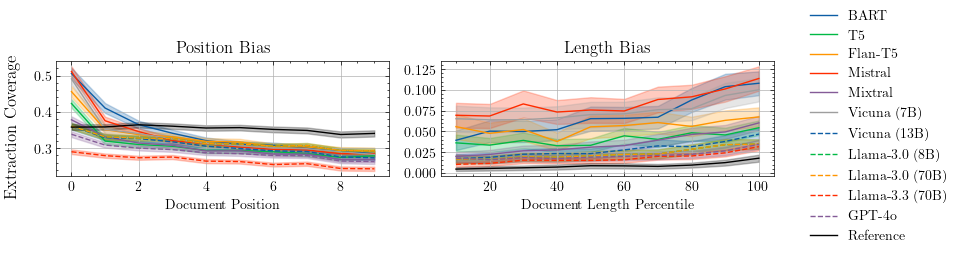

In [29]:
fig, axs = plt.subplots(1, 2, figsize = (8, 2))

for i, ((model, length_res), (model, pos_res)) in enumerate(zip(length_ress.items(), pos_ress.items())):

    linestyle = '--' if i >= 6 else '-'
    color = f'C{i}' if i < 5 else f'C{i+1}'
    if i == len(length_ress) - 1:
        color = 'black'
        linestyle = '-'

    
    pos_res['mp_ext'] = (pos_res['mpl_ext'] + pos_res['mpr_ext']) / 2
    pos_res['mp_ext_std'] = (pos_res['mpl_ext_std'] + pos_res['mpr_ext_std']) / 2
    axs[0].plot(np.array(pos_res['pos']), pos_res['mp_ext'], label = model_names[i], color = color, linestyle = linestyle)

    axs[0].fill_between(np.array(pos_res['pos']), 
                     np.array(pos_res['mp_ext']) - np.array(pos_res['mp_ext_std']), 
                     np.array(pos_res['mp_ext']) + np.array(pos_res['mp_ext_std']),
                    alpha = alpha, color = color)
    
    length_res['mp_ext_unq'] = (length_res['mpl_ext_unq'] + length_res['mpr_ext_unq']) / 2
    length_res['mp_ext_unq_std'] = (length_res['mpl_ext_unq_std'] + length_res['mpr_ext_unq_std']) / 2
    axs[1].plot((length_res.index.get_level_values('length_bin') + 1) * 10, length_res['mp_ext_unq'], color = color, linestyle = linestyle)

    axs[1].fill_between((length_res.index.get_level_values('length_bin') + 1) * 10, 
                     np.array(length_res['mp_ext_unq']) - np.array(length_res['mp_ext_unq_std']), 
                     np.array(length_res['mp_ext_unq']) + np.array(length_res['mp_ext_unq_std']),
                    alpha = alpha, color = color)

fig.supylabel('Extraction Coverage')
axs[0].set_xlabel('Document Position')
axs[1].set_xlabel('Document Length Percentile')

axs[0].set_title('Position Bias')
axs[1].set_title('Length Bias')

axs[0].grid()

loc = plticker.MultipleLocator(base=0.025)
axs[1].yaxis.set_major_locator(loc)
axs[1].grid()
    
fig.legend(ncols = 1, loc = 'center left', bbox_to_anchor = (1.01, 0.5))

fig.tight_layout()
plt.savefig('figures/unique_pos_length_comb_clipped.png', dpi = 600)